# Hyper parameter training for part 5

In [169]:
import seaborn as sns
import pandas as pd
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
%matplotlib inline


In [170]:
# import data
train_data = pd.read_csv('Training.csv')

train_data.describe(include='all')


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style,category
count,29189.000000,29189,29189,29189,29189,29185,29189,29184,2.918900e+04,6047.000000,600,15365,29189
unique,NaN,2,4866,27588,24102,23305,28807,21768,NaN,NaN,600,6104,6
top,NaN,True,"01 3, 2017",AA7918E9410D650A076221C7B2934A09,6E46168E5DFA83876F2E968A187B9F7A,760C63E8E5E8DC3FAA01878D37BA5678,works great,Five Stars,NaN,NaN,['https://images-na.ssl-images-amazon.com/imag...,{'Format:': ' Audio CD'},CDs
freq,NaN,22996,40,32,36,1049,25,1476,NaN,NaN,1,4296,4912
mean,2.971907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.409661e+09,7.295353,NaN,NaN,NaN
std,1.410878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.115099e+08,18.749460,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.947584e+08,2.000000,NaN,NaN,NaN
25%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.390781e+09,2.000000,NaN,NaN,NaN
50%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.439770e+09,4.000000,NaN,NaN,NaN
75%,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.476317e+09,7.000000,NaN,NaN,NaN


In [171]:
import re

# Preprocessing data

# Stop words
GENERIC_STOP_WORDS = []  # removed stop words to gather more data for multiclassification


# edit text
def edit_text(content):

    # step 1 - convert the text to only lower case
    content = content.lower()

    # step 2 - remove unwanted and unicode characters
    content = re.sub(
        r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", content)

    # step 3 - remove stop words
    stopwords = GENERIC_STOP_WORDS

    filtered_words = [
        word for word in content.split() if word not in stopwords]
    text = " ".join(filtered_words)

    return text


# create categories for vote label
def assign_vote_label(i):
    if i <= 2.0:
        return 'low'
    if i > 2.0 and i <= 10.0:
        return 'medium'
    if i > 10.0 and i <= 50.0:
        return 'good'
    if i > 50.0:
        return 'high'


# preprocess
def preprocess(data):

    # filter out only important columns
    X_cols = ['reviewText', 'summary', 'verified', 'vote', 'category']

    # editing text of "reviewText" & "summary"
    data['reviewText'] = data['reviewText'].astype(str).apply(edit_text)
    data['summary'] = data['summary'].astype(str).apply(edit_text)

    # editing vote - assigning NAN values to 0
    data['vote'] = data['vote'].fillna(0)
    data['vote'] = data['vote'].apply(lambda x: assign_vote_label(x))

    X = train_data[X_cols]

    return X


In [172]:

# creating X and y data

# creating y labels
y = train_data['overall'].astype(int)

# create features data
X = preprocess(train_data)


In [173]:
from sklearn.model_selection import train_test_split

# train test split function
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, random_state = 101)


In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, accuracy_score, auc
from sklearn.exceptions import ConvergenceWarning
import warnings


# define the column transformer to apply TfidfVectorizer & encoder to multiple columns
ct = ColumnTransformer(
    [
        ("vect_summary", TfidfVectorizer(), 'summary'),
        ("vect_reviewText", TfidfVectorizer(), 'reviewText'),
        ("encd_verified", OrdinalEncoder(dtype=int), ['verified']),
        ("encd_category", OrdinalEncoder(dtype=int), ['category']),
        ("encd_votes", OrdinalEncoder(dtype=int), ['vote']),
    ])

# ignore warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# For results
model_arr, auc_arr, f1_arr, accuracy_arr = [], [], [], []


# Multinomial Naive Bayes

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START classifier__alpha=0.01, classifier__fit_prior=True, transformer__vect_reviewText__max_features=10000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=15000, transformer__vect_summary__ngram_range=(1, 2)
[CV 1/5; 1/40] END classifier__alpha=0.01, classifier__fit_prior=True, transformer__vect_reviewText__max_features=10000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=15000, transformer__vect_summary__ngram_range=(1, 2);, score=0.559 total time=   2.5s
[CV 2/5; 1/40] START classifier__alpha=0.01, classifier__fit_prior=True, transformer__vect_reviewText__max_features=10000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=15000, transformer__vect_summary__ngram_range=(1, 2)
[CV 2/5; 1/40] END classifier__alpha=0.01, classifier__fit_prior=True, transformer__vect_reviewText__max_feat

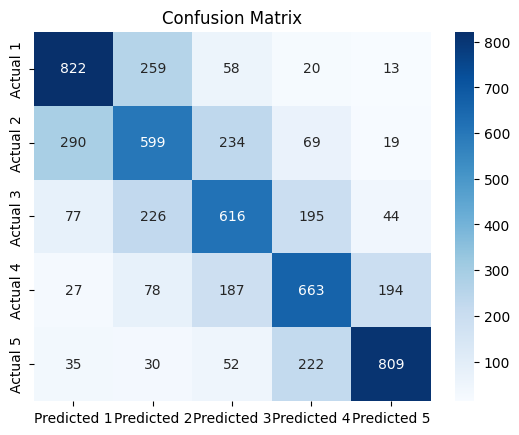

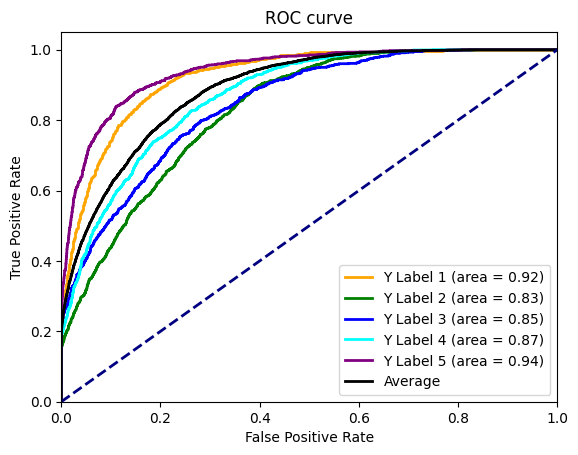

In [175]:
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline([
    ("transformer", ct),
    ("classifier", MultinomialNB())
])

mnbModel_params = {
    "transformer__vect_summary__ngram_range": [(1, 2)],
    "transformer__vect_reviewText__ngram_range": [(1, 2)],
    "transformer__vect_summary__max_features": [15000, 35000],
    "transformer__vect_reviewText__max_features": [10000, 15000],
    "classifier__alpha": [0.01, 0.1, 0.5, 1, 10],
    'classifier__fit_prior': [True, False],
}


# perform grid search cross-validation to find the best hyperparameters
grid_mnb = GridSearchCV(pipe, mnbModel_params, cv=5,
                        scoring='f1_macro', verbose=10)

grid_mnb.fit(X_train, y_train)
print("Best: %f using %s" % (grid_mnb.best_score_, grid_mnb.best_params_))

# predict
y_pred_mnb = grid_mnb.best_estimator_.predict(X_test)

# f1 score
fscore = f1_score(y_test, y_pred_mnb, average='macro')
print("f1_score: ", fscore)
f1_arr.append(fscore)

# accuracy
accu = accuracy_score(y_test, y_pred_mnb)
accuracy_arr.append(accu)
print("accuracy: ", accu)

# ROC curve & AUC Score
y_pred_prob_mnb = grid_mnb.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_prob_mnb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"auc score for Y = {i+1}: ", roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_onehot_test.ravel(), y_pred_prob_mnb.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("auc score average: ", roc_auc["micro"])
auc_arr.append(roc_auc["micro"])

# confusion matrix
cm = confusion_matrix(y_test, y_pred_mnb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 1', 'Predicted 2',
                         'Predicted 3', 'Predicted 4', 'Predicted 5'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3', 'Actual 4', 'Actual 5'])
plt.title("Confusion Matrix")
plt.show()

# Plot the ROC curve for each class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='orange', lw=lw,
         label='Y Label 1 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=lw,
         label='Y Label 2 (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue', lw=lw,
         label='Y Label 3 (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='cyan', lw=lw,
         label='Y Label 4 (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='purple', lw=lw,
         label='Y Label 5 (area = %0.2f)' % roc_auc[4])
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=lw, label='Average')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

model_arr.append("MultinomialNB")


# Logistic Regression

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START classifier__C=0.1, classifier__max_iter=100, classifier__solver=liblinear, transformer__vect_reviewText__max_features=10000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=15000, transformer__vect_summary__ngram_range=(1, 2)
[CV 1/5; 1/48] END classifier__C=0.1, classifier__max_iter=100, classifier__solver=liblinear, transformer__vect_reviewText__max_features=10000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=15000, transformer__vect_summary__ngram_range=(1, 2);, score=0.576 total time=   3.9s
[CV 2/5; 1/48] START classifier__C=0.1, classifier__max_iter=100, classifier__solver=liblinear, transformer__vect_reviewText__max_features=10000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=15000, transformer__vect_summary__ngram_range=(1, 2)
[CV 2/5; 1/48] END classifier__C=0.1, cl

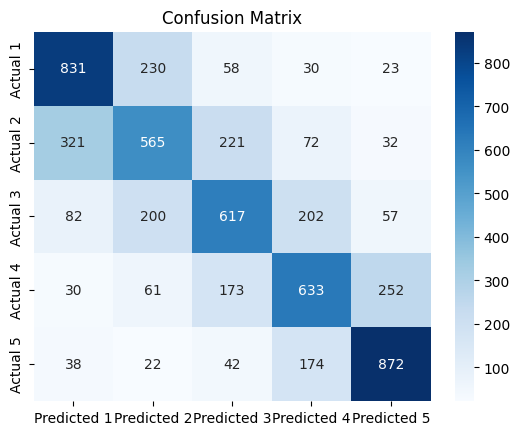

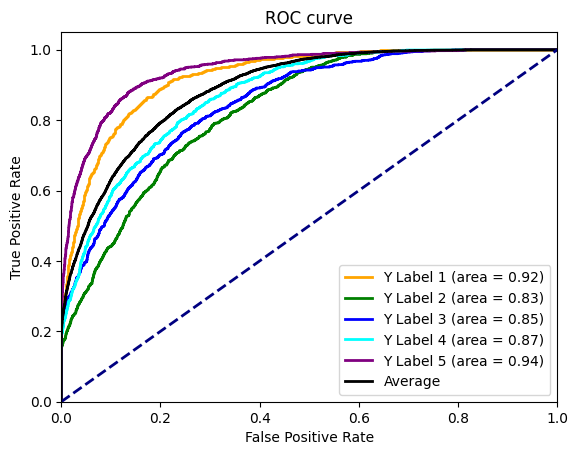

In [176]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("transformer", ct),
    ("classifier", LogisticRegression())
])

log_params = {
    "transformer__vect_summary__ngram_range": [(1, 2)],
    "transformer__vect_reviewText__ngram_range": [(1, 2)],
    "transformer__vect_summary__max_features": [15000, 35000],
    "transformer__vect_reviewText__max_features": [10000, 15000],
    "classifier__solver": ['liblinear'],
    "classifier__C": [0.1, 1.0, 5.0, 10.0],
    "classifier__max_iter": [100, 500, 1000]
}


# perform grid search cross-validation to find the best hyperparameters
grid_log = GridSearchCV(pipe, log_params, cv=5, scoring='f1_macro', verbose=10)

grid_log.fit(X_train, y_train)
print("-----------------------------------------------------------------------------------------------------------------------------------")
print("Best: %f using %s" % (grid_log.best_score_, grid_log.best_params_))

# predict
y_pred_log = grid_log.best_estimator_.predict(X_test)

# f1 score
fscore = f1_score(y_test, y_pred_log, average='macro')
print("f1_score: ", fscore)
f1_arr.append(fscore)

# accuracy
accu = accuracy_score(y_test, y_pred_log)
accuracy_arr.append(accu)
print("accuracy: ", accu)

# ROC curve & AUC Score
y_pred_prob_log = grid_log.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_prob_log[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"auc score for Y = {i+1}: ", roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_onehot_test.ravel(), y_pred_prob_log.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("auc score average: ", roc_auc["micro"])
auc_arr.append(roc_auc["micro"])

# confusion matrix
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 1', 'Predicted 2',
                         'Predicted 3', 'Predicted 4', 'Predicted 5'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3', 'Actual 4', 'Actual 5'])
plt.title("Confusion Matrix")
plt.show()

# Plot the ROC curve for each class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='orange', lw=lw,
         label='Y Label 1 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=lw,
         label='Y Label 2 (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue', lw=lw,
         label='Y Label 3 (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='cyan', lw=lw,
         label='Y Label 4 (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='purple', lw=lw,
         label='Y Label 5 (area = %0.2f)' % roc_auc[4])
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=lw, label='Average')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

model_arr.append("Logistic Regression")


# SVC

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START classifier__estimator__C=10, classifier__estimator__penalty=l1, transformer__vect_reviewText__max_features=10000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=15000, transformer__vect_summary__ngram_range=(1, 2)
[CV 1/5; 1/32] END classifier__estimator__C=10, classifier__estimator__penalty=l1, transformer__vect_reviewText__max_features=10000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=15000, transformer__vect_summary__ngram_range=(1, 2);, score=nan total time=   1.9s
[CV 2/5; 1/32] START classifier__estimator__C=10, classifier__estimator__penalty=l1, transformer__vect_reviewText__max_features=10000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=15000, transformer__vect_summary__ngram_range=(1, 2)
[CV 2/5; 1/32] END classifier__estimator__C=10, classifier__estimator__pena

/Users/shyamreddy/.pyenv/versions/3.9.2/envs/mlenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shyamreddy/.pyenv/versions/3.9.2/envs/mlenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shyamreddy/.pyenv/versions/3.9.2/envs/mlenv/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/shyamreddy/.pyenv/versions/3.9.2/en

-----------------------------------------------------------------------------------------------------------------------------------
Best: 0.600283 using {'classifier__estimator__C': 0.1, 'classifier__estimator__penalty': 'l2', 'transformer__vect_reviewText__max_features': 15000, 'transformer__vect_reviewText__ngram_range': (1, 2), 'transformer__vect_summary__max_features': 35000, 'transformer__vect_summary__ngram_range': (1, 2)}
f1_score:  0.6029277215858294
accuracy:  0.606200753682768
auc score for Y = 1:  0.9238213333255312
auc score for Y = 2:  0.8261164810646304
auc score for Y = 3:  0.8496069704618927
auc score for Y = 4:  0.8677330477919823
auc score for Y = 5:  0.9407421268470985
auc score average:  0.887788543207425


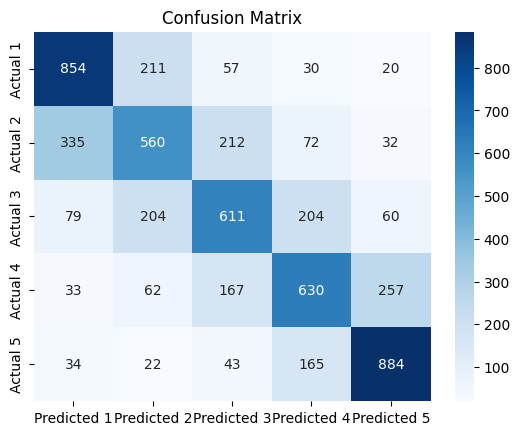

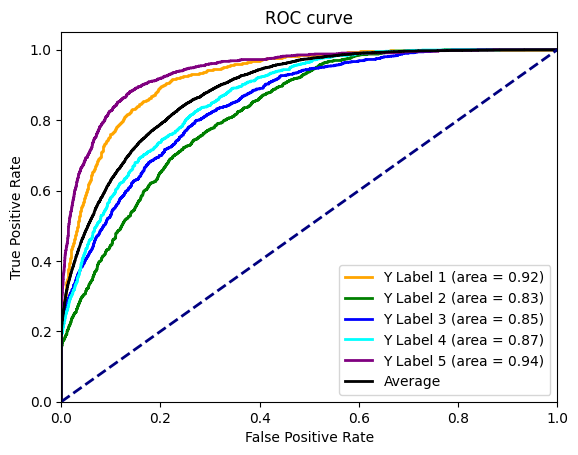

In [177]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

pipe = Pipeline([
    ("transformer", ct),
    ("classifier", CalibratedClassifierCV(LinearSVC()))
])

svcModel_params = {
    "transformer__vect_summary__ngram_range": [(1, 2)],
    "transformer__vect_reviewText__ngram_range": [(1, 2)],
    "transformer__vect_summary__max_features": [15000, 35000],
    "transformer__vect_reviewText__max_features": [10000, 15000],
    "classifier__estimator__C": [10, 1, 0.1, 0.01],
    "classifier__estimator__penalty": ['l1', 'l2'],
}


# perform grid search cross-validation to find the best hyperparameters
grid_svc = GridSearchCV(pipe, svcModel_params, cv=5, scoring='f1_macro', verbose=10)

grid_svc.fit(X_train, y_train)
print("-----------------------------------------------------------------------------------------------------------------------------------")
print("Best: %f using %s" % (grid_svc.best_score_, grid_svc.best_params_))

# predict
y_pred_svc = grid_svc.best_estimator_.predict(X_test)

# f1 score
fscore = f1_score(y_test, y_pred_svc, average='macro')
print("f1_score: ", fscore)
f1_arr.append(fscore)

# accuracy
accu = accuracy_score(y_test, y_pred_svc)
accuracy_arr.append(accu)
print("accuracy: ", accu)

# ROC curve & AUC Score
y_pred_prob_svc = grid_svc.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_prob_svc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"auc score for Y = {i+1}: ", roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_onehot_test.ravel(), y_pred_prob_svc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("auc score average: ", roc_auc["micro"])
auc_arr.append(roc_auc["micro"])

# confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 1', 'Predicted 2',
                         'Predicted 3', 'Predicted 4', 'Predicted 5'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3', 'Actual 4', 'Actual 5'])
plt.title("Confusion Matrix")
plt.show()

# Plot the ROC curve for each class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='orange', lw=lw,
         label='Y Label 1 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=lw,
         label='Y Label 2 (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue', lw=lw,
         label='Y Label 3 (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='cyan', lw=lw,
         label='Y Label 4 (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='purple', lw=lw,
         label='Y Label 5 (area = %0.2f)' % roc_auc[4])
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=lw, label='Average')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

model_arr.append("LinearSVC")


# SGD

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START classifier__estimator__alpha=0.001, classifier__estimator__loss=hinge, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2)
[CV 1/5; 1/32] END classifier__estimator__alpha=0.001, classifier__estimator__loss=hinge, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2);, score=0.588 total time=   2.9s
[CV 2/5; 1/32] START classifier__estimator__alpha=0.001, classifier__estimator__loss=hinge, transformer__vect_reviewText__max_features=5000, transformer__vect_reviewText__ngram_range=(1, 2), transformer__vect_summary__max_features=10000, transformer__vect_summary__ngram_range=(1, 2)
[CV 2/5; 1/32] END classifier__estimator__alpha=0.001, 

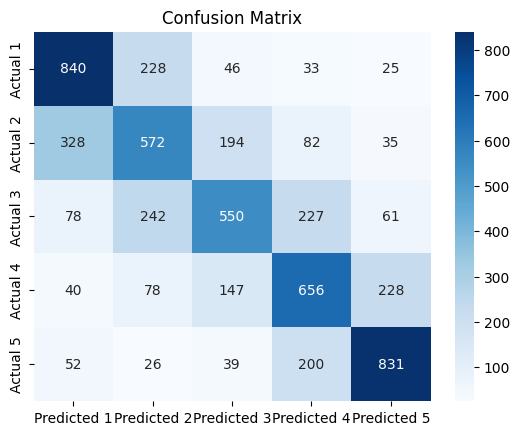

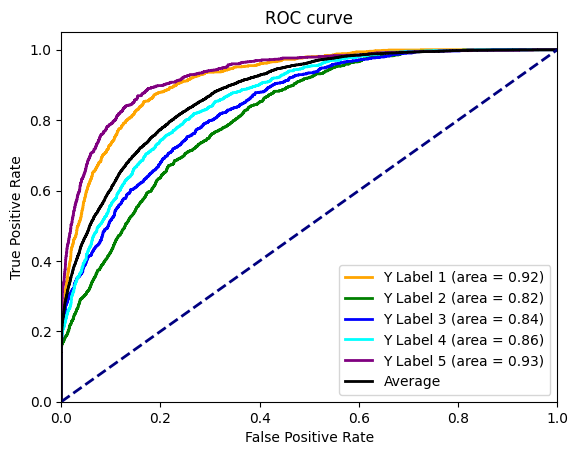

In [178]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

pipe = Pipeline([
    ("transformer", ct),
    ("classifier", CalibratedClassifierCV(estimator = SGDClassifier()))
])

sgd_params = {
    "transformer__vect_summary__ngram_range": [(1, 2)],
    "transformer__vect_reviewText__ngram_range": [(1, 2)],
    "transformer__vect_summary__max_features": [10000, 32000],
    "transformer__vect_reviewText__max_features": [5000, 10000],
    "classifier__estimator__alpha": [0.001, 0.01, 0.1, 1],
    "classifier__estimator__loss": ['hinge', 'perceptron'],
}


# perform grid search cross-validation to find the best hyperparameters
grid_sgd = GridSearchCV(pipe, sgd_params, cv=5, scoring='f1_macro', verbose=10)

grid_sgd.fit(X_train, y_train)
print("-----------------------------------------------------------------------------------------------------------------------------------")
print("Best: %f using %s" % (grid_sgd.best_score_, grid_sgd.best_params_))

# predict
y_pred_sgd = grid_sgd.best_estimator_.predict(X_test)

# f1 score
fscore = f1_score(y_test, y_pred_sgd, average='macro')
print("f1_score: ", fscore)
f1_arr.append(fscore)

# accuracy
accu = accuracy_score(y_test, y_pred_sgd)
accuracy_arr.append(accu)
print("accuracy: ", accu)

# ROC curve & AUC Score
y_pred_prob_sgd = grid_sgd.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_pred_prob_sgd[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"auc score for Y = {i+1}: ", roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_onehot_test.ravel(), y_pred_prob_sgd.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("auc score average: ", roc_auc["micro"])
auc_arr.append(roc_auc["micro"])

# confusion matrix
cm = confusion_matrix(y_test, y_pred_sgd)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 1', 'Predicted 2',
                         'Predicted 3', 'Predicted 4', 'Predicted 5'],
            yticklabels=['Actual 1', 'Actual 2', 'Actual 3', 'Actual 4', 'Actual 5'])
plt.title("Confusion Matrix")
plt.show()

# Plot the ROC curve for each class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='orange', lw=lw,
         label='Y Label 1 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=lw,
         label='Y Label 2 (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue', lw=lw,
         label='Y Label 3 (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='cyan', lw=lw,
         label='Y Label 4 (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='purple', lw=lw,
         label='Y Label 5 (area = %0.2f)' % roc_auc[4])
plt.plot(fpr["micro"], tpr["micro"], color='black', lw=lw, label='Average')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

model_arr.append("Stochastic Gradient classifier")


In [179]:
pd.DataFrame({"Model": model_arr, "auc": auc_arr,
      "f1 score": f1_arr, "Accuracy": accuracy_arr, }).head()


,Model,auc,f1 score,Accuracy
0,MultinomialNB,0.887109,0.602023,0.601062
1,Logistic Regression,0.888729,0.600205,0.602604
2,LinearSVC,0.887789,0.602928,0.606201
3,Stochastic Gradient classifier,0.879063,0.588616,0.590785
